In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
goog_data = pd.read_csv('GOOG.csv')
crm_data = pd.read_csv('CRM.csv')
hpe_data = pd.read_csv('HPE.csv')
insider_data = pd.read_csv('insiderdata.csv')

In [5]:
# Convert 'Date' columns to datetime format
goog_data['Date'] = pd.to_datetime(goog_data['Date'], format='%Y-%m-%d')
crm_data['Date'] = pd.to_datetime(crm_data['Date'], format='%Y-%m-%d')
hpe_data['Date'] = pd.to_datetime(hpe_data['Date'], format='%Y-%m-%d')
insider_data['Transaction Date'] = pd.to_datetime(insider_data['Transaction Date'], format='%Y-%m-%d')

print("GOOG Stock Data:")
print(goog_data.head(), "\n")

print("Insider Trades Data:")
print(insider_data.head())

# Filter insider trades to include only GOOG, CRM, and HPE
filtered_trades = insider_data[insider_data['Issuer Trading Symbol'].isin(['GOOG', 'CRM', 'HPE'])]

# Check how many trades are found for each stock
for symbol in ['GOOG', 'CRM', 'HPE']:
    print(f"Number of {symbol} insider trades: {len(filtered_trades[filtered_trades['Issuer Trading Symbol'] == symbol])}")

GOOG Stock Data:
        Date       Open       High        Low      Close    Volume  Dividends  \
0 2004-08-19  49.813290  51.835709  47.800831  49.982655  44871361          0   
1 2004-08-20  50.316402  54.336334  50.062355  53.952770  22942874          0   
2 2004-08-23  55.168217  56.528118  54.321388  54.495735  18342897          0   
3 2004-08-24  55.412300  55.591629  51.591621  52.239197  15319808          0   
4 2004-08-25  52.284027  53.798351  51.746044  52.802086   9232276          0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0   

Insider Trades Data:
   Unnamed: 0.1  Unnamed: 0 Buy/Sell Transaction Date Acceptance Date Time  \
0             0           0     Sell       2017-01-04  2017-01-06 20:57:22   
1             1           1     Sell       2017-01-05  2017-01-06 20:46:33   
2             2           2     Sell       2017-01-06  2017-01-06 20:46:02   
3             3           3     Sell       2017-01-04

In [6]:
def extract_stock_window(trade_date, stock_data):
    """Extracts exactly 7 trading days before and 7 trading days after the trade date."""
    stock_data = stock_data.sort_values('Date')
    pre_trade = stock_data[stock_data['Date'] < trade_date].tail(7)
    post_trade = stock_data[stock_data['Date'] >= trade_date].head(7)
    window_data = pd.concat([pre_trade, post_trade])
    print(f"Window size for {trade_date}: {len(window_data)} rows")
    return window_data

In [8]:
def generate_features(window_data):
    """Generates comprehensive features from the stock price window."""

    # Work on a copy
    window_data = window_data.copy()

    # Calculate pct change in closing prices
    window_data['Close_pct_change'] = window_data['Close'].pct_change()

    # Split data into pre-trade (first 7 days) and post-trade (next 7 days)
    pre_trade_data = window_data.iloc[:7]
    post_trade_data = window_data.iloc[7:]

    # Calculate averages and volatility for full window
    avg_change = window_data['Close_pct_change'].mean()
    volatility = window_data['Close_pct_change'].std()
    avg_volume = window_data['Volume'].mean()

    # Pre-trade metrics
    pre_avg = pre_trade_data['Close'].mean()
    pre_volatility = pre_trade_data['Close_pct_change'].std()
    pre_avg_volume = pre_trade_data['Volume'].mean()
    pre_price_change = pre_trade_data['Close'].iloc[-1] - pre_trade_data['Close'].iloc[0]
    pre_pct_price_change = (pre_price_change / pre_trade_data['Close'].iloc[0]) if pre_trade_data['Close'].iloc[0] != 0 else 0

    # Post-trade metrics
    post_avg = post_trade_data['Close'].mean()
    post_volatility = post_trade_data['Close_pct_change'].std()
    post_avg_volume = post_trade_data['Volume'].mean()
    post_price_change = post_trade_data['Close'].iloc[-1] - post_trade_data['Close'].iloc[0]
    post_pct_price_change = (post_price_change / post_trade_data['Close'].iloc[0]) if post_trade_data['Close'].iloc[0] != 0 else 0

    # Calculate total price change before and after the trade
    total_price_change = post_trade_data['Close'].iloc[-1] - pre_trade_data['Close'].iloc[0]
    total_pct_price_change = (total_price_change / pre_trade_data['Close'].iloc[0]) if pre_trade_data['Close'].iloc[0] != 0 else 0

    # Percentage changes between pre and post periods
    pct_change_avg = (post_avg - pre_avg) / pre_avg if pre_avg != 0 else 0
    pct_change_volatility = (post_volatility - pre_volatility) / pre_volatility if pre_volatility != 0 else 0
    pct_change_volume = (post_avg_volume - pre_avg_volume) / pre_avg_volume if pre_avg_volume != 0 else 0

    # Return all features as a list
    '''
    return [
        avg_change, volatility, avg_volume,  # Full window metrics
        pre_avg, post_avg,                   # Pre and post-trade averages
        pre_volatility, post_volatility,     # Pre and post-trade volatility
        pre_avg_volume, post_avg_volume,     # Pre and post-trade average volume
        pre_price_change, post_price_change, # Absolute price change pre/post-trade
        pre_pct_price_change, post_pct_price_change,  # % price change pre/post-trade
        total_price_change, total_pct_price_change,  # Total price change
        pct_change_avg,                      # % change in average close price
        pct_change_volatility,               # % change in volatility
        pct_change_volume                    # % change in average volume
    ]
    '''


In [11]:
# Initialize list for features
feature_data = []

# Loop through each company and generate features
for symbol, stock_data in zip(['GOOG', 'CRM', 'HPE'], [goog_data, crm_data, hpe_data]):
    trades = filtered_trades[filtered_trades['Issuer Trading Symbol'] == symbol]
    
    # Remove duplicate transaction dates for this symbol
    unique_trades = trades.drop_duplicates(subset=['Transaction Date'])
    
    for index, trade in unique_trades.iterrows():
        trade_date = trade['Transaction Date']
        print(f"Processing {symbol} trade on: {trade_date}")
        window_data = extract_stock_window(trade_date, stock_data)
        if len(window_data) < 14:
            print(f"Incomplete window for trade on {trade_date}. Skipping...")
            continue
        features = generate_features(window_data)
        features.append(1)  # Label = 1 (Insider trade)
        feature_data.append(features)


# Create DataFrame for positive samples
columns = [
    'Avg_Change', 'Volatility', 'Avg_Volume', 
    'Pre_Trade_Avg', 'Post_Trade_Avg', 
    'Pre_Trade_Volatility', 'Post_Trade_Volatility',
    'Pre_Trade_Avg_Volume', 'Post_Trade_Avg_Volume',
    'Pre_Price_Change', 'Post_Price_Change', 
    'Pre_Pct_Price_Change', 'Post_Pct_Price_Change',
    'Total_Price_Change', 'Total_Pct_Price_Change',
    'Pct_Change_Avg', 'Pct_Change_Volatility', 'Pct_Change_Volume',
    'Label'
]
feature_df = pd.DataFrame(feature_data, columns=columns)
feature_df.to_csv('insider_features.csv', index=False)
print("Feature dataset created successfully!")
print(f"Feature DataFrame shape: {feature_df.shape}")


Processing GOOG trade on: 2017-01-03 00:00:00
Window size for 2017-01-03 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-28 00:00:00
Window size for 2016-12-28 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-29 00:00:00
Window size for 2016-12-29 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-27 00:00:00
Window size for 2016-12-27 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-23 00:00:00
Window size for 2016-12-23 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-21 00:00:00
Window size for 2016-12-21 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-22 00:00:00
Window size for 2016-12-22 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-20 00:00:00
Window size for 2016-12-20 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-19 00:00:00
Window size for 2016-12-19 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-07 00:00:00
Window size for 2016-12-07 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-05 00:00:00
Window size for 2016-12-05 00:00:00: 14 rows

In [12]:
print(feature_df)

     Avg_Change  Volatility    Avg_Volume  Pre_Trade_Avg  Post_Trade_Avg  \
0      0.001319    0.008921  1.177650e+06     786.705706      798.937151   
1      0.001517    0.008939  1.256907e+06     792.671422      787.552865   
2      0.001234    0.008902  1.173393e+06     791.849993      790.638585   
3     -0.000338    0.008326  1.255929e+06     793.571420      785.467146   
4     -0.000959    0.007856  1.282286e+06     794.594282      784.879996   
..          ...         ...           ...            ...             ...   
96     0.004405    0.016650  2.577499e+07      11.468117       11.844882   
97     0.001726    0.014413  2.652332e+07      11.470930       11.589019   
98     0.005418    0.016328  1.722048e+07      10.862202       11.341593   
99     0.004240    0.015900  1.810186e+07      10.879072       11.437893   
100    0.004915    0.016470  1.678640e+07      10.824245       11.141964   

     Pre_Trade_Volatility  Post_Trade_Volatility  Pre_Trade_Avg_Volume  \
0            

In [14]:
import random

# Initialize an empty list to store negative features
negative_data = []

# Use a set to track selected windows and avoid duplicates
seen_windows = set()

# Generate random windows for negative samples
num_negative_samples = len(feature_df)  # Same number as positive samples

for _ in range(num_negative_samples):
    # Select a random start index for the 14-day window
    random_index = random.randint(0, len(stock_data) - 15)  # Ensure room for 14 days
    window_data = stock_data.iloc[random_index : random_index + 14]

    # Create a unique key to track this window (using its dates)
    window_key = tuple(window_data['Date'].values)

    # Skip if this window has already been seen
    if window_key in seen_windows:
        print("Duplicate window detected. Skipping...")
        continue

    # Add this window to the set of seen windows
    seen_windows.add(window_key)

    # Generate features for this window
    features = generate_features(window_data)
    features.append(0)  # Label = 0 (Non-insider trade)
    negative_data.append(features)

# Define the feature columns (same as positive samples)
columns = [
    'Avg_Change', 'Volatility', 'Avg_Volume', 
    'Pre_Trade_Avg', 'Post_Trade_Avg', 
    'Pre_Trade_Volatility', 'Post_Trade_Volatility',
    'Pre_Trade_Avg_Volume', 'Post_Trade_Avg_Volume',
    'Pre_Price_Change', 'Post_Price_Change', 
    'Pre_Pct_Price_Change', 'Post_Pct_Price_Change',
    'Total_Price_Change', 'Total_Pct_Price_Change',
    'Pct_Change_Avg', 'Pct_Change_Volatility', 'Pct_Change_Volume',
    'Label'
]

# Create a DataFrame with the negative features
negative_df = pd.DataFrame(negative_data, columns=columns)

# Save the DataFrame to a CSV file for further analysis
negative_df.to_csv('goog_negative_features.csv', index=False)

print("Negative feature dataset created successfully!")
print(f"Negative DataFrame shape: {negative_df.shape}")



Duplicate window detected. Skipping...
Duplicate window detected. Skipping...
Duplicate window detected. Skipping...
Negative feature dataset created successfully!
Negative DataFrame shape: (98, 19)


In [15]:
print(negative_data)

[[0.008333616923711724, 0.014243934592832238, 13892064.285714285, 11.793277740478516, 12.290744372776576, 0.014075182186267774, 0.010885300406207775, 18020585.714285713, 9763542.857142856, 1.150747299194336, 0.2962522506713885, 0.10229046111266855, 0.024242819176022275, 1.266657829284668, 0.1125938018887494, 0.04218221967168522, -0.2266316512174284, -0.4582005817156728, 0], [0.00806452221486859, 0.017546851462496252, 11689271.42857143, 12.74886417388916, 13.657328060695104, 0.01717408233562212, 0.018150071091878522, 8506914.285714285, 14871628.57142857, 0.24799633026123225, 0.8236913681030273, 0.01977428195866261, 0.06300815973625519, 1.3551073074340838, 0.1080510907287186, 0.07125841756684181, 0.05682916485336899, 0.7481813113366605, 0], [-0.006742156477185124, 0.015883311565059094, 8877707.142857144, 14.069906098502022, 13.203359740121025, 0.009919834633273547, 0.01907760717657896, 7455828.571428572, 10299585.714285715, -0.09812259674072088, -0.9009494781494158, -0.006975197707660118

In [17]:
all_data = feature_data + negative_data
all_df = pd.DataFrame(all_data, columns=columns)
all_df.to_csv('all_features.csv', index=False)
print(all_data)

[[0.0013191235324159735, 0.00892145157995812, 1177650.0, 786.7057059151786, 798.9371512276786, 0.005612459193131996, 0.007941285622524347, 1037728.5714285715, 1317571.4285714286, -22.739990234375, 21.76995849609375, -0.02861960116825296, 0.02769221524212744, 13.3499755859375, 0.016801721238115845, 0.015547675859641948, 0.4149386836063151, 0.26966864442945443, 1], [0.001516673298922287, 0.008938897274129528, 1256907.142857143, 792.6714215959821, 787.5528651646206, 0.0033485888279750297, 0.012126782437741162, 1174700.0, 1339114.2857142857, 0.75, 21.10003662109375, 0.000948406691422901, 0.02687731602978917, 15.35003662109375, 0.019410769926709186, -0.006457349529589085, 2.6214605795822687, 0.1399627868513541, 1], [0.0012336546379664816, 0.008901614758774488, 1173392.857142857, 791.8499930245536, 790.6385846819196, 0.004074175894307403, 0.011231437850554745, 990414.2857142857, 1356371.4285714286, -9.1500244140625, 23.86004638671875, -0.011521058012370416, 0.030480776525584608, 12.450012207

In [23]:
# LETS DO SOME ML!df = pd.read_csv('all_features.csv')
print(len(df))
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

199
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       1.00      0.94      0.97        52

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

[[48  0]
 [ 3 49]]


In [25]:
from sklearn.model_selection import cross_val_score

# Cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Average accuracy: {scores.mean():.4f}")


Cross-validation scores: [0.975      0.975      1.         1.         0.64102564]
Average accuracy: 0.9182


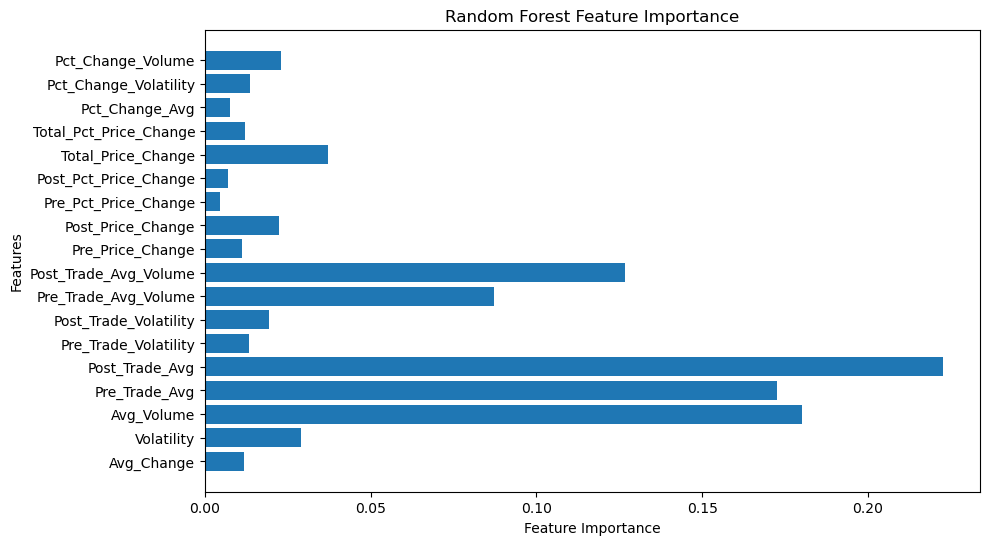

In [27]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()


In [91]:
#overfitting test

# Initialize a list to store the features of the 50 test windows
overfitting_test_data = []

# Use a set to track selected windows to avoid duplicates
seen_windows = set()

# Generate 50 random non-overlapping windows for overfitting check
num_test_windows = 50

for _ in range(num_test_windows):
    # Randomly select a 14-day window from the stock data
    random_index = random.randint(0, len(stock_data) - 15)  # Ensure space for 14 days
    window_data = stock_data.iloc[random_index : random_index + 14]

    # Create a unique key using the window's dates to track it
    window_key = tuple(window_data['Date'].values)

    # Skip if this window has already been selected
    if window_key in seen_windows:
        print("Duplicate window detected. Skipping...")
        continue

    # Add the window to the seen set
    seen_windows.add(window_key)

    # Generate features for the selected window
    features = generate_features(window_data)
    overfitting_test_data.append(features)

# Convert the test data to a DataFrame
columns = [
    'Avg_Change', 'Volatility', 'Avg_Volume', 
    'Pre_Trade_Avg', 'Post_Trade_Avg', 
    'Pre_Trade_Volatility', 'Post_Trade_Volatility',
    'Pre_Trade_Avg_Volume', 'Post_Trade_Avg_Volume',
    'Pre_Price_Change', 'Post_Price_Change', 
    'Pre_Pct_Price_Change', 'Post_Pct_Price_Change',
    'Total_Price_Change', 'Total_Pct_Price_Change',
    'Pct_Change_Avg', 'Pct_Change_Volatility', 'Pct_Change_Volume'
]

overfitting_test_df = pd.DataFrame(overfitting_test_data, columns=columns)

# Make predictions using the trained model
predictions = model.predict(overfitting_test_df)

# Analyze the predictions
num_predicted_as_insider = np.sum(predictions)
num_predicted_as_non_insider = len(predictions) - num_predicted_as_insider

print(f"Out of 50 random non-insider windows:")
print(f"Predicted as insider trades: {num_predicted_as_insider}")
print(f"Predicted as non-insider trades: {num_predicted_as_non_insider}")

Out of 50 random non-insider windows:
Predicted as insider trades: 6
Predicted as non-insider trades: 44
